# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
##Reading the dataset.
df = pd.read_csv('datasets/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [38]:
##Checking the dataset.
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


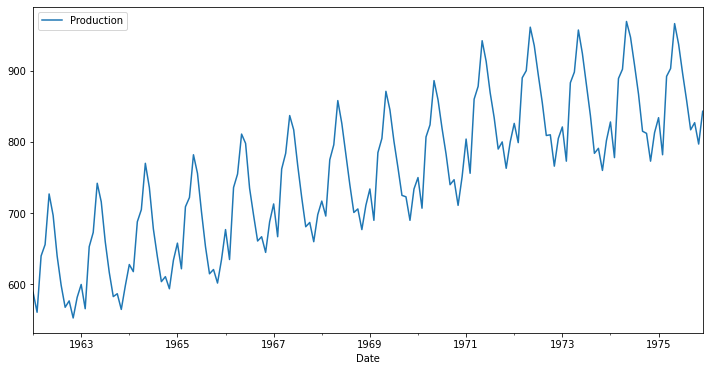

In [8]:
##PLotting the dataset to see if there is any seasonality, trend
df.plot(figsize=(12,6))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


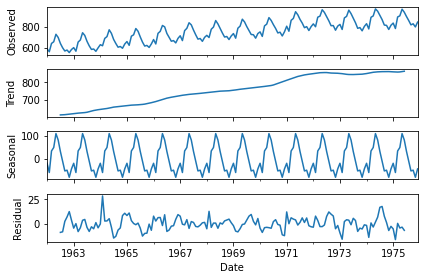

In [10]:
##Here we are breaking the graph into 3 parts.
##1st shows if there is any trend.
##2nd shows if there is any seasonality.
##3rd shows if there is any noise.

results = seasonal_decompose(df['Production'])
results.plot();

**No need to check for stationarity. As LSTM's do not need stationary data. They can perform good on Non-stationary data as well. They can learn complex patterns in the data.**

In [11]:
##checking the length of the dataset
len(df)

168

In [12]:
###Taking the last 12 months for test and remaining for train.
train = df.iloc[:156]
test = df.iloc[156:]

In [13]:
##Scaling the data to get the values between 0 and 1.
##Later we will scale them back to the original data.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [15]:
##Performing steps to scale.
##Scaling the train and test.
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
scaled_train[:10]  #Checking the scaled values.

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [17]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# define generator
##Here it would take 1st 3 inputs and predict the 4th one.
##n_features stand for how many variables are there.
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
## This would give us a series of inputs which are ready to be given to the LSTM model.

In [19]:
##Example of the generator.
X,y = generator[0]  ## The tuple is given the values as X the predictor and y is the output.
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [20]:
X.shape

(1, 3, 1)

In [21]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
## This generates a sequence of length 12 which would be given to LSTM model.

In [22]:
###Importing Libraries for implementing LSTM.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
# define model
model = Sequential()   ###Initialising a Sequential model.
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))  ### The activation used is relu.
model.add(Dense(1))  ###adding a dense layer.
model.compile(optimizer='adam', loss='mse')  ### We are using the optimizer adam. And the loss function as mse.

In [25]:
model.summary()   ##Checking the summary.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
# fit model
model.fit(generator,epochs=50)  ##Fitting the model on the generator with 50 epochs.

Epoch 1/50
144/144 [==============================] - 2s 4ms/step - loss: 0.0375
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0240
Epoch 3/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0162
Epoch 4/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0157
Epoch 5/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0100
Epoch 6/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0091
Epoch 7/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0063
Epoch 8/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 9/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 10/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 11/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 12/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0079
Epoch 13/50
144/144 [====

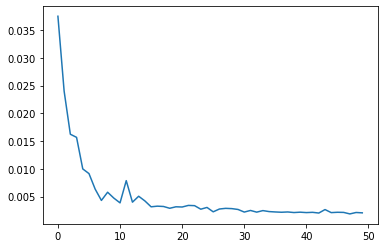

In [26]:
##Plotting the loss.
## We can see that we could have stopped at 30th epoch. As not much significant loss after 30.
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [27]:
last_train_batch = scaled_train[-12:]  ## Last 12 batch train values.

In [28]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features)) ##reshaping the train set.

In [29]:
model.predict(last_train_batch) ### Predicting the last batch Values.

array([[0.6798378]], dtype=float32)

In [30]:
scaled_test[0] ## Comparing the value with the actual value.

array([0.67548077])

**Predicting the output**

In [31]:
test_predictions = [] ## An empty List

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [32]:
test_predictions

[array([0.6798378], dtype=float32),
 array([0.62834376], dtype=float32),
 array([0.85340154], dtype=float32),
 array([0.92260325], dtype=float32),
 array([1.0602425], dtype=float32),
 array([1.0285168], dtype=float32),
 array([0.9350591], dtype=float32),
 array([0.8207084], dtype=float32),
 array([0.69440764], dtype=float32),
 array([0.6587587], dtype=float32),
 array([0.59395736], dtype=float32),
 array([0.6472162], dtype=float32)]

In [33]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [34]:
## To watch the actual prediction value, we will inverse tranform the predicted values.
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


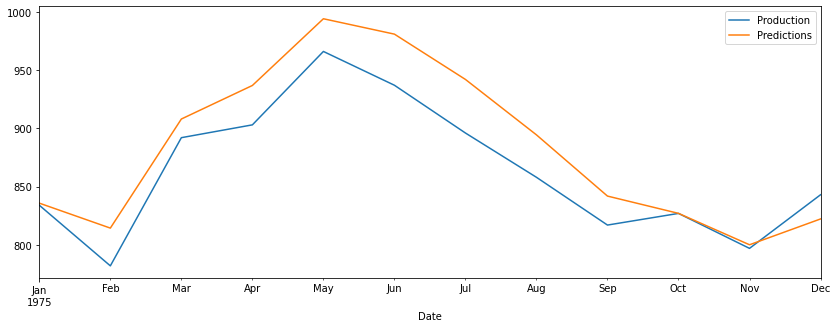

In [36]:
##Plotting the Predicted values and the actual values.
test.plot(figsize=(14,5))

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

28.376468698761347


In [ ]:
##RMSE value is 28 which is pretty good.
##HEnce this model performs extremely well.